# Bayesian analysis of the empirical saturation point (refactored version)

In [74]:
import seaborn as sns
from modules.DataSets import GenericDataSet, NormDistDataSet, KernelDensityEstimate
from modules.EftPredictions import *
from modules.StatisticalModel import StatisticalModel

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os
pdf_path = "./pdf"
if not os.path.exists(pdf_path):
    os.mkdir(pdf_path)

## Constraints from density functional theory

In [34]:
dft_constraints = {
    "Dutra_skyrme": GenericDataSet(filenames=["satpoints_dutra_skyrme.csv"]),
    "Kortelainen": GenericDataSet(filenames=["satpoints_kortelainen.csv"]),
    "Brown": GenericDataSet(filenames=["brown/satpoints_brown.csv"]),
    "Dutra_rmf": GenericDataSet(filenames=["satpoints_rmf_dutra_2014.csv"]),
    "FSU": NormDistDataSet(set_specifier="fsu_rmf"),
    "Schunck": KernelDensityEstimate(set_specifier="schunck")
}
# now add the saturation box from Drischler et al. (2016)
drischler = dft_constraints["Dutra_skyrme"] + dft_constraints["Kortelainen"]

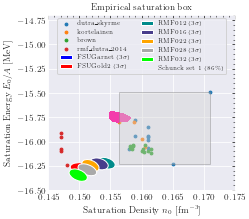

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(1.25*6.8*cm, 1.2*6.8*cm))
for key, val in dft_constraints.items():
    val.plot(ax=ax)
drischler.plot(ax=ax, plot_scatter=False, plot_box_estimate=True)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_1, beta_0]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 49 seconds.


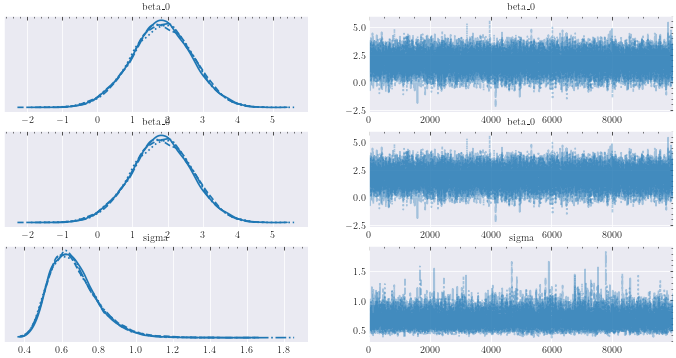

In [6]:
eft_pred = EftPredictions()
eft_pred.corner_plot()
eft_pred.plot(ax=ax)

In [7]:
fig.savefig(f"{pdf_path}/refactored_overview.pdf")

## Data management

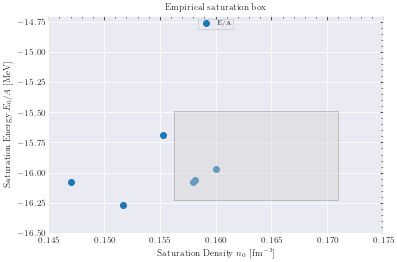

In [66]:
sampled_dft_constraints = pd.DataFrame()
for key, val in dft_constraints.items():
    sampled_dft_constraints = val.sample(df=sampled_dft_constraints)

ax = sampled_dft_constraints.plot(x="rho0", y="E/A", linestyle="None", marker="o")
drischler.plot(ax=ax, plot_scatter=False, plot_box_estimate=True)

In [67]:
sampled_dft_constraints  # one realization: "universe"  #TODO: average of different realizations

,label,rho0,E/A,class,file
3,Ska35,0.158000,-16.080000,dutra_skyrme,satpoints_dutra_skyrme.csv
0,SLy4,0.160000,-15.972000,kortelainen,satpoints_kortelainen.csv
5,brown:6,0.158140,-16.065010,brown,brown/satpoints_brown.csv
2,BSR11,0.147000,-16.080000,rmf_dutra_2014,satpoints_rmf_dutra_2014.csv
0,RMF022,0.151736,-16.270165,fsu_rmf,data/Piekarewicz/RMF022/CovEllipse.com
2026,schunck:3,0.155321,-15.690841,schunck:3,data/Schunck/samples3.csv


In [72]:
prior_params = {"mu": np.array([0.16, -15.9]),
                "Psi": np.array([[0.01**2, 0], [0, 0.32**2]]),
                "kappa": 1, "nu": 4}  # TODO: this prior is way too uninformed for the "true" nuclear saturation point. Make it realistic.
spoint = StatisticalModel(data=sampled_dft_constraints,
                          quantities=["rho0", "E/A"],
                          prior_params=prior_params)
spoint.sanity_check(num_samples=100000, based_on="prior", do_print=True)

sanity check based on predictive 'prior'
quantiles conj. prior: [[  0.14078566 -16.5164004 ]
 [  0.15999137 -15.90210142]
 [  0.17913287 -15.290098  ]]
quantiles brute-force: [[  0.14074433 -16.51385907]
 [  0.15999758 -15.8991352 ]
 [  0.17895251 -15.27636536]]
passed: True


True

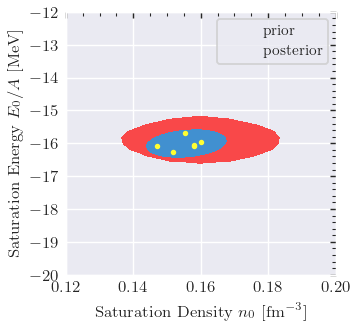

In [76]:
from modules.plot_helpers import *
fig, ax = plt.subplots(1, 1, figsize=(6.8*cm, 6.8*cm))
levels = [0.16, 1.]
for ibon, bon in enumerate(("prior", "posterior")):
    dd = spoint.sample(num_samples=500000, kind="predictive_y", based_on=bon)  # 500000
    sns.kdeplot(ax=ax, x=dd[:,0], y=dd[:,1], fill=True, levels=levels,
                label=f"{bon}",
                legend=False, color=colors[ibon])  # TODO: sns.kdeplot() seems to have issues with displaying the handles in legends
    # TODO: how to plot the credibility regions without KDE and ideally even without sampling??
ax.scatter(spoint.data["rho0"], spoint.data["E/A"], s=4, c=colors[5])
ax.set_xlim(0.12, 0.20)
ax.set_ylim(-20., -12.)
ax.set_xlabel('Saturation Density $n_0$ [fm$^{-3}$]')
ax.set_ylabel('Saturation Energy $E_0/A$ [MeV]')
ax.legend(ncol=1, prop={'size': 8})
#ax.set_title("Empirical saturation box")
fig.savefig(f"{pdf_path}/output.pdf")

In [ ]:
#TODO: use `sample_predictive_bf()` to sample over universes and marginalize